In [12]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn.functional as F

In [13]:
DATA_DIR = '/kaggle/input/outpainting/data_1'

In [14]:
IMG_SIZE = 512
PATCH_SIZE = 16
GRID_SIZE = IMG_SIZE // PATCH_SIZE
EMBED_DIM = 512
DEPTH = 8
NUM_HEADS = 8
BATCH_SIZE = 4
EPOCHS = 150
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [15]:
class OutpaintDataset(Dataset):
    def __init__(self, root_dir, img_size=256):
        self.root_dir = root_dir
        self.originals = sorted(glob.glob(os.path.join(root_dir, 'images', '*.*')))
        self.masks = sorted(glob.glob(os.path.join(root_dir, 'masks', '*.*')))

        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        self.mask_transform = transforms.Compose([
            transforms.Resize((img_size, img_size), interpolation=transforms.InterpolationMode.NEAREST),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.originals)

    def __getitem__(self, idx):
        try:
            orig = Image.open(self.originals[idx]).convert("RGB")
            mask = Image.open(self.masks[idx]).convert("L")
        except:
            return torch.zeros(3, IMG_SIZE, IMG_SIZE), torch.zeros(1, IMG_SIZE, IMG_SIZE)

        x = self.transform(orig)
        m = self.mask_transform(mask)
        m = (m > 0.5).float()

        return x, m

In [16]:
class VGGPerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        for x in range(2): self.slice1.add_module(str(x), vgg[x])
        for x in range(2, 7): self.slice2.add_module(str(x), vgg[x])
        for x in range(7, 12): self.slice3.add_module(str(x), vgg[x])
        for p in self.parameters(): p.requires_grad = False

    def forward(self, input, target):
        h1 = self.slice1(input); h1_t = self.slice1(target)
        h2 = self.slice2(h1); h2_t = self.slice2(h1_t)
        h3 = self.slice3(h2); h3_t = self.slice3(h2_t)
        loss = F.l1_loss(h1, h1_t) + F.l1_loss(h2, h2_t) + F.l1_loss(h3, h3_t)
        return loss

In [17]:
class CNN_Connector(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size=3, padding=1, groups=dim),
            nn.BatchNorm2d(dim),
            nn.GELU(),
            nn.Conv2d(dim, dim, kernel_size=1)
        )

    def forward(self, x_grid):
        return self.net(x_grid) + x_grid

In [18]:
class QueryOTR_Block(nn.Module):
    def __init__(self, dim, heads):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, batch_first=True)

        self.norm2 = nn.LayerNorm(dim)
        self.cnn_connector = CNN_Connector(dim)

        self.norm3 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim*4), nn.GELU(), nn.Linear(dim*4, dim)
        )

    def forward(self, x, grid_size):
        B, N, C = x.shape

        x_norm = self.norm1(x)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + attn_out

        x_2d = x.transpose(1, 2).reshape(B, C, grid_size, grid_size)
        x_2d = self.cnn_connector(x_2d)
        x_cnn = x_2d.flatten(2).transpose(1, 2)

        x = self.norm2(x + x_cnn)

        x = x + self.ffn(self.norm3(x))
        return x

In [19]:
class AutoContext_QueryOTR(nn.Module):
    def __init__(self, img_size=256, patch_size=16, dim=512, depth=6, heads=8):
        super().__init__()
        self.patch_size = patch_size
        self.grid_size = img_size // patch_size
        self.num_patches = self.grid_size ** 2

        self.patch_embed = nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size)

        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches, dim))

        self.mask_token = nn.Parameter(torch.randn(1, 1, dim))

        self.blocks = nn.ModuleList([
            QueryOTR_Block(dim, heads) for _ in range(depth)
        ])

        self.head = nn.Sequential(
            nn.ConvTranspose2d(dim, 256, 4, 2, 1), nn.LeakyReLU(),
        )
        self.linear_head = nn.Linear(dim, 3 * patch_size * patch_size)

    def forward(self, img, mask):
        B = img.shape[0]

        x = self.patch_embed(img)
        x = x.flatten(2).transpose(1, 2)

        x = x + self.pos_embed

        mask_grid = F.interpolate(mask, size=(self.grid_size, self.grid_size), mode='nearest')
        mask_tokens = mask_grid.flatten(2).transpose(1, 2)

        mask_t = self.mask_token.expand(B, self.num_patches, -1)
        x = x * mask_tokens + mask_t * (1 - mask_tokens)

        for blk in self.blocks:
            x = blk(x, self.grid_size)

        patches = self.linear_head(x)

        img_recon = self.unpatchify(patches)

        return img_recon

    def unpatchify(self, x):
        p = self.patch_size
        h = w = self.grid_size
        B = x.shape[0]
        x = x.reshape(B, h, w, 3, p, p)
        x = torch.einsum('nhwcqp->nchpwq', x)
        imgs = x.reshape(B, 3, h * p, h * p)
        return imgs

In [20]:
def train():
    dataset = OutpaintDataset(DATA_DIR, img_size=IMG_SIZE)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    model = AutoContext_QueryOTR(img_size=IMG_SIZE, patch_size=PATCH_SIZE, dim=EMBED_DIM, depth=DEPTH).to(DEVICE)

    optimizer = optim.AdamW(model.parameters(), lr=LR)
    l1_loss = nn.L1Loss()
    vgg_loss = VGGPerceptualLoss().to(DEVICE)


    for epoch in range(EPOCHS):
        model.train()
        ep_loss = 0

        for img, mask in dataloader:
            img = img.to(DEVICE)
            mask = mask.to(DEVICE)

            # Forward
            pred_img = model(img, mask)

            # Loss
            loss_pix = l1_loss(pred_img, img)
            loss_vgg = vgg_loss(pred_img, img)
            total_loss = loss_pix + 0.1 * loss_vgg

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            ep_loss += total_loss.item()

        print(f"Epoch {epoch+1}: Loss {ep_loss/len(dataloader):.4f}")

        if (epoch+1) % 10 == 0:
            torch.save(model.state_dict(), f"queryotr_ep{epoch+1}.pth")

            model.eval()
            with torch.no_grad():
                sample_img, sample_mask = next(iter(dataloader))
                sample_img = sample_img.to(DEVICE)
                sample_mask = sample_mask.to(DEVICE)

                sample_pred = model(sample_img, sample_mask)

                inp = sample_img[0] * 0.5 + 0.5
                out = sample_pred[0] * 0.5 + 0.5
                msk = sample_mask[0]

                input_vis = inp * msk

                output_vis = out * (1 - msk) + inp * msk

                input_vis = input_vis.permute(1, 2, 0).cpu().numpy()
                output_vis = output_vis.permute(1, 2, 0).cpu().numpy()
                gt_vis = inp.permute(1, 2, 0).cpu().numpy()

                plt.figure(figsize=(12, 4))

                plt.subplot(1, 3, 1)
                plt.imshow(np.clip(input_vis, 0, 1))
                plt.title("Input")
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(np.clip(output_vis, 0, 1))
                plt.title(f"Output")
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(np.clip(gt_vis, 0, 1))
                plt.title("Ground Truth")
                plt.axis('off')

                plt.show()

    torch.save(model.state_dict(), "queryotr_final.pth")

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 203MB/s] 


Epoch 1: Loss 0.6093
Epoch 2: Loss 0.5915
Epoch 3: Loss 0.5789
Epoch 4: Loss 0.5734
Epoch 5: Loss 0.5699
Epoch 6: Loss 0.5658
Epoch 7: Loss 0.5625
Epoch 8: Loss 0.5597
Epoch 9: Loss 0.5570
Epoch 10: Loss 0.5530


Epoch 11: Loss 0.5474
Epoch 12: Loss 0.5431
Epoch 13: Loss 0.5374
Epoch 14: Loss 0.5334
Epoch 15: Loss 0.5256
Epoch 16: Loss 0.5199
Epoch 17: Loss 0.5155
Epoch 18: Loss 0.5078
Epoch 19: Loss 0.5012
Epoch 20: Loss 0.4939


Epoch 21: Loss 0.4895
Epoch 22: Loss 0.4820
Epoch 23: Loss 0.4775
Epoch 24: Loss 0.4724
Epoch 25: Loss 0.4692
Epoch 26: Loss 0.4643
Epoch 27: Loss 0.4609
Epoch 28: Loss 0.4570
Epoch 29: Loss 0.4535
Epoch 30: Loss 0.4494


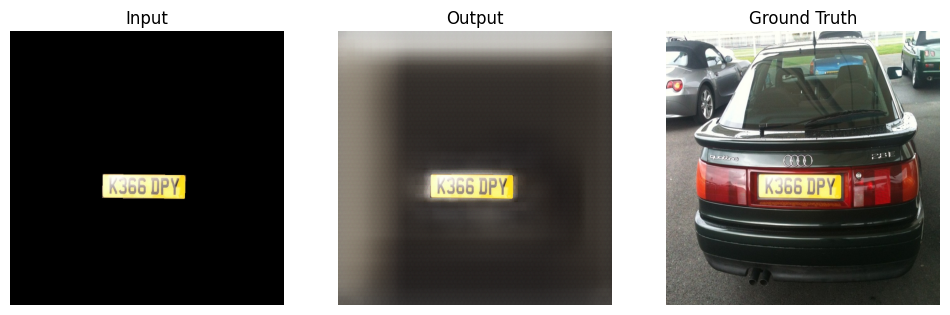

Epoch 31: Loss 0.4480
Epoch 32: Loss 0.4449
Epoch 33: Loss 0.4408
Epoch 34: Loss 0.4378
Epoch 35: Loss 0.4333
Epoch 36: Loss 0.4307
Epoch 37: Loss 0.4289
Epoch 38: Loss 0.4255
Epoch 39: Loss 0.4228
Epoch 40: Loss 0.4214


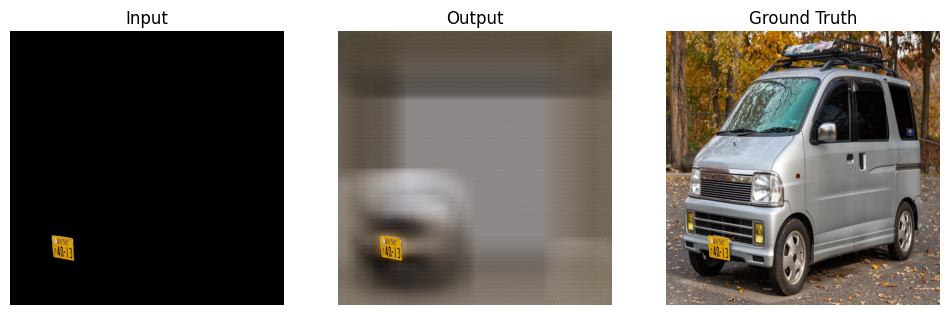

Epoch 41: Loss 0.4187
Epoch 42: Loss 0.4161
Epoch 43: Loss 0.4132
Epoch 44: Loss 0.4111
Epoch 45: Loss 0.4086
Epoch 46: Loss 0.4068
Epoch 47: Loss 0.4049
Epoch 48: Loss 0.4026
Epoch 49: Loss 0.4001
Epoch 50: Loss 0.3984


Epoch 51: Loss 0.3961
Epoch 52: Loss 0.3935
Epoch 53: Loss 0.3921
Epoch 54: Loss 0.3898
Epoch 55: Loss 0.3874
Epoch 56: Loss 0.3862
Epoch 57: Loss 0.3843
Epoch 58: Loss 0.3821
Epoch 59: Loss 0.3811
Epoch 60: Loss 0.3795


Epoch 61: Loss 0.3770
Epoch 62: Loss 0.3760
Epoch 63: Loss 0.3736
Epoch 64: Loss 0.3731
Epoch 65: Loss 0.3714
Epoch 66: Loss 0.3701
Epoch 67: Loss 0.3678
Epoch 68: Loss 0.3670
Epoch 69: Loss 0.3664
Epoch 70: Loss 0.3641


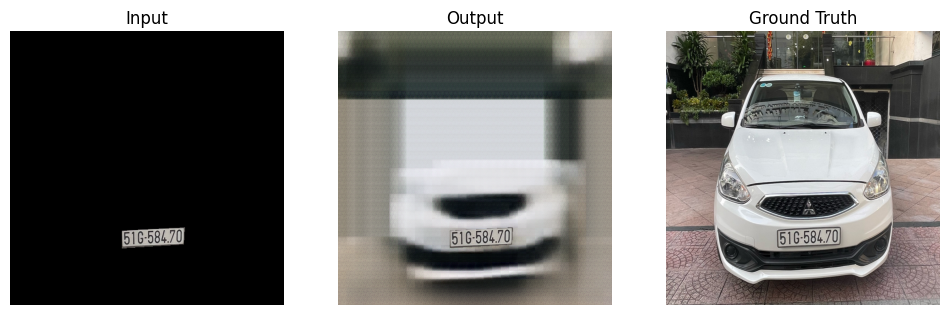

Epoch 71: Loss 0.3629
Epoch 72: Loss 0.3620
Epoch 73: Loss 0.3615
Epoch 74: Loss 0.3599
Epoch 75: Loss 0.3588
Epoch 76: Loss 0.3579
Epoch 77: Loss 0.3558
Epoch 78: Loss 0.3547
Epoch 79: Loss 0.3541
Epoch 80: Loss 0.3536


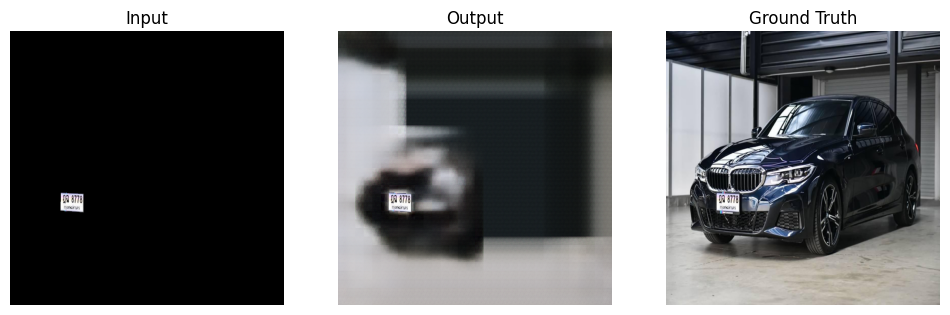

Epoch 81: Loss 0.3514
Epoch 82: Loss 0.3496
Epoch 83: Loss 0.3497
Epoch 84: Loss 0.3490
Epoch 85: Loss 0.3475
Epoch 86: Loss 0.3465
Epoch 87: Loss 0.3458
Epoch 88: Loss 0.3451
Epoch 89: Loss 0.3448
Epoch 90: Loss 0.3446


Epoch 91: Loss 0.3426
Epoch 92: Loss 0.3417
Epoch 93: Loss 0.3410
Epoch 94: Loss 0.3403
Epoch 95: Loss 0.3397
Epoch 96: Loss 0.3388
Epoch 97: Loss 0.3376
Epoch 98: Loss 0.3368
Epoch 99: Loss 0.3360
Epoch 100: Loss 0.3360


Epoch 101: Loss 0.3358
Epoch 102: Loss 0.3348
Epoch 103: Loss 0.3338
Epoch 104: Loss 0.3331
Epoch 105: Loss 0.3325
Epoch 106: Loss 0.3315
Epoch 107: Loss 0.3313
Epoch 108: Loss 0.3310
Epoch 109: Loss 0.3297
Epoch 110: Loss 0.3285


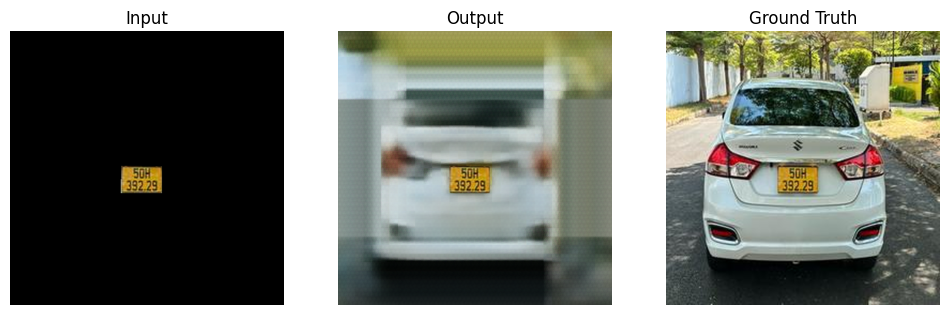

Epoch 111: Loss 0.3283
Epoch 112: Loss 0.3280
Epoch 113: Loss 0.3277
Epoch 114: Loss 0.3325
Epoch 115: Loss 0.3350
Epoch 116: Loss 0.3287
Epoch 117: Loss 0.3239
Epoch 118: Loss 0.3223
Epoch 119: Loss 0.3217
Epoch 120: Loss 0.3216


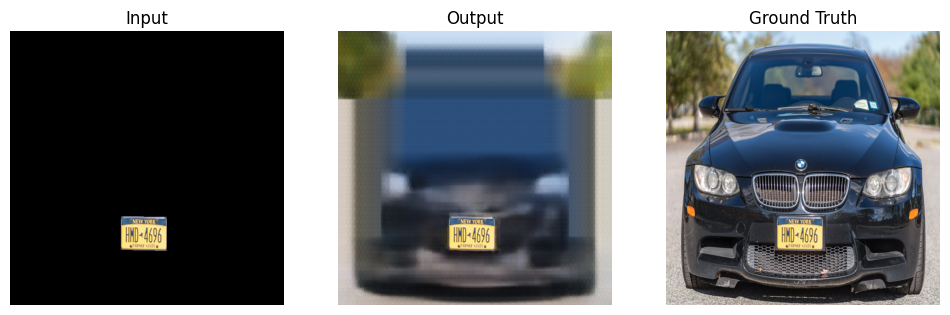

Epoch 121: Loss 0.3222
Epoch 122: Loss 0.3226
Epoch 123: Loss 0.3223
Epoch 124: Loss 0.3219
Epoch 125: Loss 0.3212
Epoch 126: Loss 0.3210
Epoch 127: Loss 0.3204
Epoch 128: Loss 0.3198
Epoch 129: Loss 0.3193
Epoch 130: Loss 0.3194


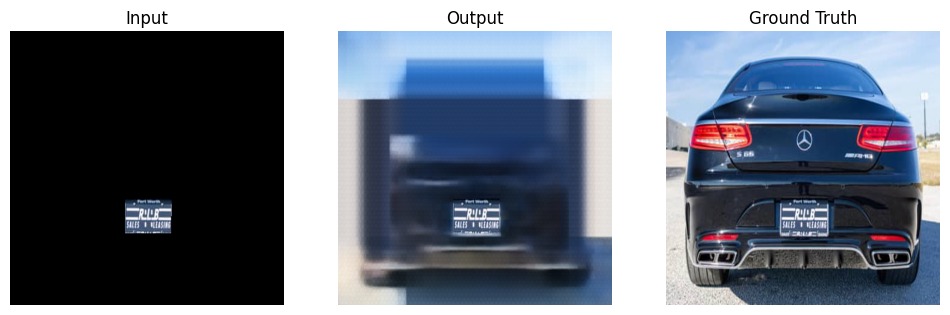

Epoch 131: Loss 0.3187
Epoch 132: Loss 0.3190
Epoch 133: Loss 0.3185
Epoch 134: Loss 0.3177
Epoch 135: Loss 0.3167
Epoch 136: Loss 0.3164
Epoch 137: Loss 0.3164
Epoch 138: Loss 0.3159
Epoch 139: Loss 0.3154
Epoch 140: Loss 0.3152


Epoch 141: Loss 0.3144
Epoch 142: Loss 0.3134
Epoch 143: Loss 0.3131
Epoch 144: Loss 0.3129
Epoch 145: Loss 0.3127
Epoch 146: Loss 0.3123
Epoch 147: Loss 0.3120
Epoch 148: Loss 0.3117
Epoch 149: Loss 0.3113
Epoch 150: Loss 0.3110


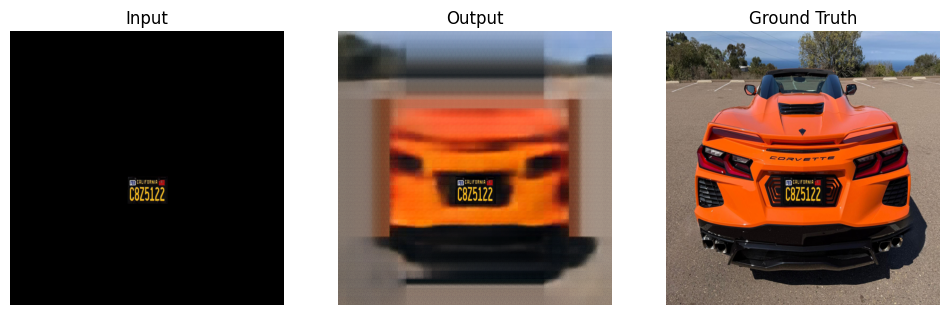

In [21]:
if __name__ == "__main__":
    train()

# Inference

In [30]:
model_save = '/kaggle/working/queryotr_final.pth'

In [31]:
def inference(crop_path, model_path=model_save): 
    
    model = AutoContext_QueryOTR(img_size=IMG_SIZE, patch_size=PATCH_SIZE, dim=EMBED_DIM, depth=DEPTH).to(DEVICE)
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()

    crop = Image.open(crop_path).convert("RGB")
    w_crop, h_crop = crop.size

    scale_ratio = 0.25 
    
    target_w = int(IMG_SIZE * scale_ratio) 
    scale = target_w / w_crop
    target_h = int(h_crop * scale)
    crop = crop.resize((target_w, target_h), Image.BICUBIC)

    canvas = Image.new("RGB", (IMG_SIZE, IMG_SIZE), (0,0,0))
    mask_canvas = Image.new("L", (IMG_SIZE, IMG_SIZE), 0)

    pos_x = (IMG_SIZE - target_w) // 2
    
    pos_y = int(IMG_SIZE * 0.65) 

    canvas.paste(crop, (pos_x, pos_y))

    mask_draw = Image.new("L", (target_w, target_h), 255)
    mask_canvas.paste(mask_draw, (pos_x, pos_y))

    norm = transforms.Normalize((0.5,)*3, (0.5,)*3)
    img_tensor = norm(transforms.ToTensor()(canvas)).unsqueeze(0).to(DEVICE)

    mask_tensor = transforms.ToTensor()(mask_canvas).unsqueeze(0).to(DEVICE)
    mask_tensor = (mask_tensor > 0.5).float()

    with torch.no_grad():
        pred_img = model(img_tensor, mask_tensor)

    out_np = pred_img[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5
    out_np = np.clip(out_np, 0, 1)
    res_pil = Image.fromarray((out_np * 255).astype(np.uint8))

    res_pil.paste(crop, (pos_x, pos_y))

    plt.figure(figsize=(8, 8))
    plt.imshow(res_pil)
    plt.axis('off')
    plt.show()

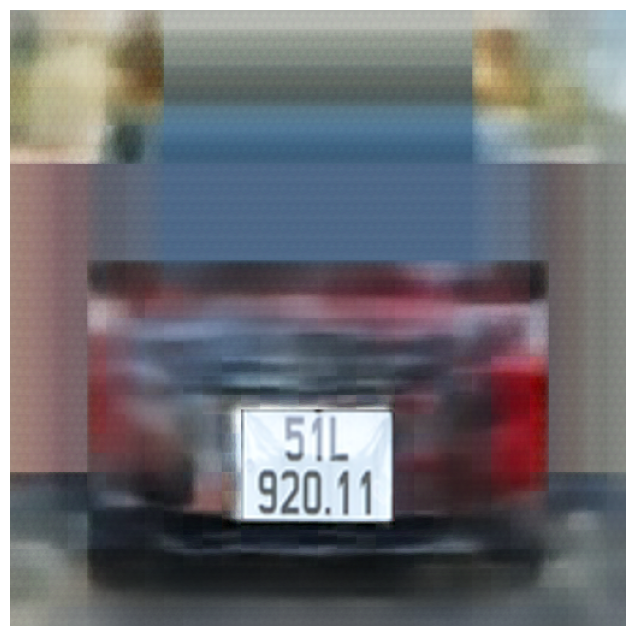

In [32]:
inference('/kaggle/input/outpainting/data_1/inference/crop_margin/image_00000.png')

In [33]:
inference('/kaggle/input/outpainting/data_1/inference/crop_margin/image_00001.png')